# Assignment 2

## Task 1:
This task is designed upon `AI1_M1_Lab4_Selction&Evaluation&Linear.ipynb`, `AI1_M1_Lab6_TreeModels_I.ipynb` and `AI1_M1_Lab6_TreeModels_II.ipynb`, with a focus on California Housing dataset.

The primary objective is conduct a comprehensive analysis through data preparation, model selection, training, and evaluation.

### 1. Introduction & Setup
In this section, we load the [California housing dataset](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html) and perform initial exploration.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

# Load the dataset
housing = fetch_california_housing(as_frame=True)
df = housing.frame.copy()

# Display description of the dataset
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

### 2. Feature Analysis with Visualization

Explore features of interest in the California Housing dataset by two distinct plots. 

The two plots should differ from those in `AI1_M1_Lab4_Selection&Evaluation&Linear.ipynb`.

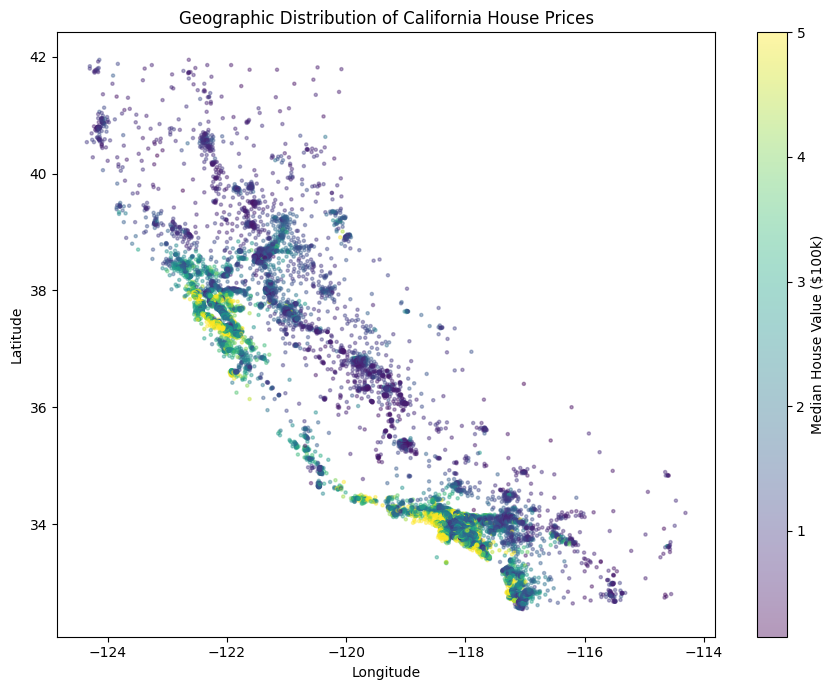

C:\Users\david\AppData\Local\Temp\ipykernel_14628\2828482963.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([normalised[col].dropna() for col in df.columns],


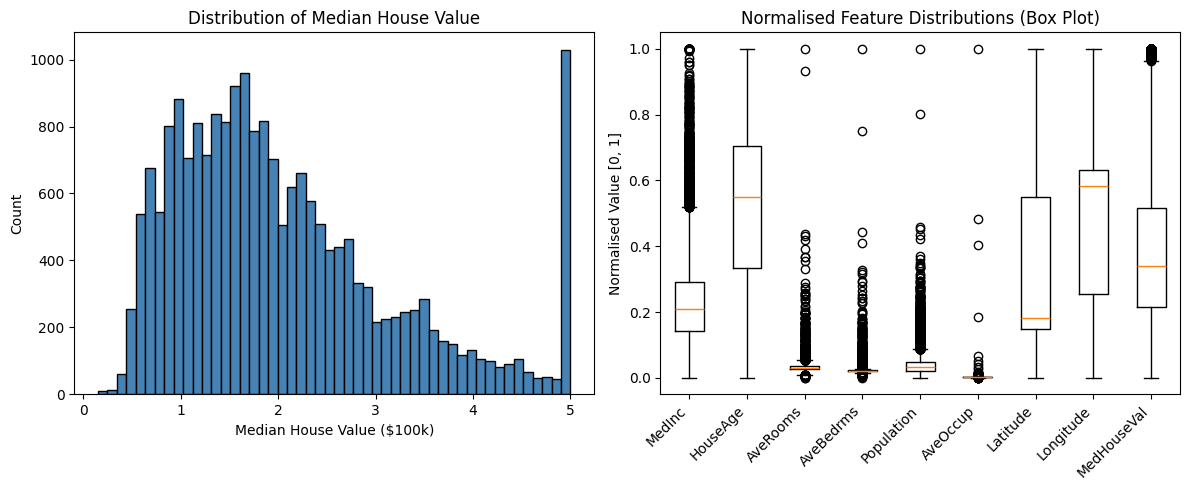

In [24]:

# Visualization
# Plot 1: Geographic distribution of house prices (Latitude vs Longitude coloured by MedHouseVal)
# This shows the spatial pattern of prices across California - different from the scatter & heatmap in the labs.
# very interesting to see this heat map, we can almost see teh contours of the state of california and 
# we can see where its more popular to live in general and also where teh hoses are generally pricier 
plt.figure(figsize=(9, 7))
sc = plt.scatter(df['Longitude'], df['Latitude'],
                 c=df['MedHouseVal'], cmap='viridis', alpha=0.4, s=5)
plt.colorbar(sc, label='Median House Value ($100k)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of California House Prices')
plt.tight_layout()
plt.show()

# Plot 2: Distribution of the target variable (MedHouseVal) as a histogram with KDE overlay
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: histogram of MedHouseVal
axes[0].hist(df['MedHouseVal'], bins=50, edgecolor='black', color='steelblue')
axes[0].set_xlabel('Median House Value ($100k)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Median House Value')

# Right: boxplot of all numeric features (normalized so they fit on one axis)
normalised = (df - df.min()) / (df.max() - df.min())
axes[1].boxplot([normalised[col].dropna() for col in df.columns],
                labels=df.columns, vert=True)
axes[1].set_xticklabels(df.columns, rotation=45, ha='right')
axes[1].set_title('Normalised Feature Distributions (Box Plot)')
axes[1].set_ylabel('Normalised Value [0, 1]')

plt.tight_layout()
plt.show()


### 3. Data preparation

Data preparation is a critical step in the machine learning process. Apply data preparation steps to ensure the dataset is properly structured and ready for training.

In [25]:

# Prepare data for training
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal']

print(f"Missing values:\n{X.isnull().sum()}")
print(f"\nDataset shape: {X.shape}")

# Train / test split  (80 % / 20 %)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features (required for KNN and linear models, harmless for trees)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Convert back to DataFrames for convenience
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=X.columns, index=X_test.index)

print(f"\nTrain size: {X_train_scaled.shape}, Test size: {X_test_scaled.shape}")
X_train_scaled.head()


Missing values:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

Dataset shape: (20640, 8)

Train size: (16512, 8), Test size: (4128, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14196,-0.326196,0.348490,-0.174916,-0.208365,0.768276,0.051376,-1.372811,1.272587
8267,-0.035843,1.618118,-0.402835,-0.128530,-0.098901,-0.117362,-0.876696,0.709162
17445,0.144701,-1.952710,0.088216,-0.257538,-0.449818,-0.032280,-0.460146,-0.447603
14265,-1.017864,0.586545,-0.600015,-0.145156,-0.007434,0.077507,-1.382172,1.232698
2271,-0.171488,1.142008,0.349007,0.086624,-0.485877,-0.068832,0.532084,-0.108551


### 4. Model selection

For ML models need to set hyperparameters before training, find the optimal combination of hyperparameters that will get the good model performance in this step.

In [26]:

# Model selection – GridSearchCV to find optimal hyperparameters (3-fold CV to keep runtime manageable)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

cv = 3  # folds

# ── 1. KNN ──────────────────────────────────────────────────────────────────
knn_grid = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={'n_neighbors': [3, 5, 7, 10, 15]},
    cv=cv, scoring='r2', n_jobs=-1
)
knn_grid.fit(X_train_scaled, y_train)
print(f"KNN      best params: {knn_grid.best_params_}  CV R²={knn_grid.best_score_:.4f}")


# == 2. Lasso (Linear model) ==============================================================
lasso_grid = GridSearchCV(
    Lasso(max_iter=10000),
    param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
    cv=cv, scoring='r2', n_jobs=-1
)
lasso_grid.fit(X_train_scaled, y_train)
print(f"Lasso    best params: {lasso_grid.best_params_}  CV R²={lasso_grid.best_score_:.4f}")

# == 2. Decision Tree ==============================================================
dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid={'max_depth': [4, 6, 8, 10, None]},
    cv=cv, scoring='r2', n_jobs=-1
)
dt_grid.fit(X_train, y_train)   # trees don't need scaling
print(f"DecTree  best params: {dt_grid.best_params_}  CV R²={dt_grid.best_score_:.4f}")

# == 2. Random Forest ==============================================================
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid={'n_estimators': [50, 100], 'max_depth': [8, 12, None]},
    cv=cv, scoring='r2', n_jobs=-1
)
rf_grid.fit(X_train, y_train)
print(f"RF       best params: {rf_grid.best_params_}  CV R²={rf_grid.best_score_:.4f}")

# == 5. Gradient Boosting ==============================================================
gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid={
        'n_estimators': [100, 200],
        'max_depth':    [3, 5],
        'min_samples_split': [2, 10]
    },
    cv=cv, scoring='r2', n_jobs=-1
)
gb_grid.fit(X_train, y_train)
print(f"GradBoost best params: {gb_grid.best_params_}  CV R²={gb_grid.best_score_:.4f}")

# == 6. AdaBoost ==============================================================
ada_grid = GridSearchCV(
    AdaBoostRegressor(random_state=42),
    param_grid={'n_estimators': range(50, 450, 50), },
    cv=cv, scoring='r2', n_jobs=-1
)
ada_grid.fit(X_train, y_train)
print(f"AdaBoost best params: {ada_grid.best_params_}  CV R²={ada_grid.best_score_:.4f}")


KNN      best params: {'n_neighbors': 15}  CV R²=0.6829
Lasso    best params: {'alpha': 0.001}  CV R²=0.6112
DecTree  best params: {'max_depth': 8}  CV R²=0.6826
RF       best params: {'max_depth': None, 'n_estimators': 100}  CV R²=0.8004
GradBoost best params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}  CV R²=0.8294
AdaBoost best params: {'n_estimators': 50}  CV R²=0.4310


### 5. Model training

Train KNN, linear model, and tree-based models.

In [27]:

# Training – extract best estimators from GridSearchCV and record predictions

# KNN and linear models use scaled features; tree models use raw features
models = {
    'KNN':           (knn_grid.best_estimator_,   X_train_scaled, X_test_scaled),
    'Lasso':         (lasso_grid.best_estimator_,  X_train_scaled, X_test_scaled),
    'Decision Tree': (dt_grid.best_estimator_,     X_train,        X_test),
    'Random Forest': (rf_grid.best_estimator_,     X_train,        X_test),
    'Gradient Boost':(gb_grid.best_estimator_,     X_train,        X_test),
    'AdaBoost':      (ada_grid.best_estimator_,    X_train,        X_test),
}

predictions = {}   # store test predictions for evaluation

for name, (model, X_tr, X_te) in models.items():
    # Re-fit on full training set with best params (GridSearchCV already did this via refit=True)
    y_pred = model.predict(X_te)
    predictions[name] = y_pred
    print(f"{name:20s} – training done, {len(y_pred)} test predictions generated")


KNN                  – training done, 4128 test predictions generated
Lasso                – training done, 4128 test predictions generated
Decision Tree        – training done, 4128 test predictions generated
Random Forest        – training done, 4128 test predictions generated
Gradient Boost       – training done, 4128 test predictions generated
AdaBoost             – training done, 4128 test predictions generated


### 6. Evaluation

Compare the results of all ML models, and find the one with the best performance.

Model Comparison (sorted by R²):
                 RMSE     R²
Gradient Boost 0.4736 0.8288
Random Forest  0.5053 0.8051
KNN            0.6471 0.6804
Decision Tree  0.6497 0.6779
Lasso          0.7446 0.5769
AdaBoost       0.7839 0.5311


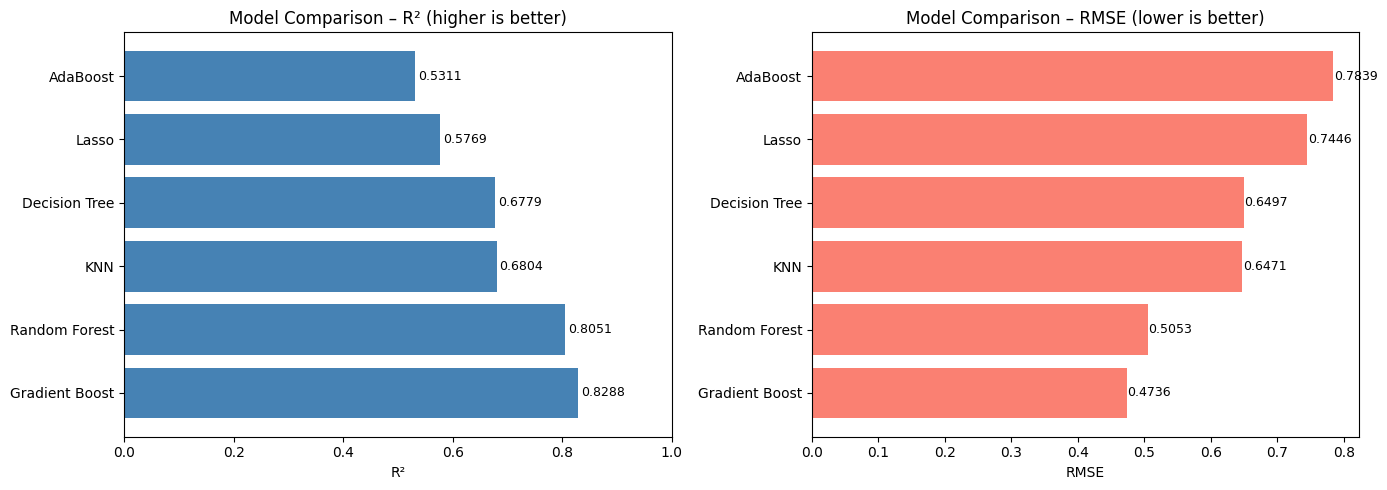


Best model: Gradient Boost  (R²=0.8288, RMSE=0.4736)


In [28]:

# Evaluation – compare all models using RMSE and R²
from sklearn.metrics import mean_squared_error, r2_score

results = {}
for name, y_pred in predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R²': r2}

results_df = pd.DataFrame(results).T.sort_values('R²', ascending=False)
print("Model Comparison (sorted by R²):")
print(results_df.to_string(float_format='{:.4f}'.format))

# ---- bar chart comparison ----
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
model_names = results_df.index

# R²
bars = axes[0].barh(model_names, results_df['R²'], color='steelblue')
axes[0].set_xlabel('R²')
axes[0].set_title('Model Comparison – R² (higher is better)')
axes[0].set_xlim(0, 1)
for bar, val in zip(bars, results_df['R²']):
    axes[0].text(val + 0.005, bar.get_y() + bar.get_height()/2,
                 f'{val:.4f}', va='center', fontsize=9)

# RMSE
bars = axes[1].barh(model_names, results_df['RMSE'], color='salmon')
axes[1].set_xlabel('RMSE')
axes[1].set_title('Model Comparison – RMSE (lower is better)')
for bar, val in zip(bars, results_df['RMSE']):
    axes[1].text(val + 0.001, bar.get_y() + bar.get_height()/2,
                 f'{val:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

best_model_name = results_df.index[0]
print(f"\nBest model: {best_model_name}  (R²={results_df.loc[best_model_name,'R²']:.4f}, "
      f"RMSE={results_df.loc[best_model_name,'RMSE']:.4f})")


### 7. Important features
Find top 3 important features by using LASSO or random forest.

LASSO – feature importances (|coefficient|):
Latitude     0.885822
Longitude    0.858093
MedInc       0.849140
AveBedrms    0.326050
AveRooms     0.281273
HouseAge     0.123346
AveOccup     0.039890
Population   0.001062

Top 3 features (LASSO): ['Latitude', 'Longitude', 'MedInc']

Random Forest – feature importances:
MedInc       0.524871
AveOccup     0.138443
Latitude     0.088936
Longitude    0.088629
HouseAge     0.054593
AveRooms     0.044272
Population   0.030650
AveBedrms    0.029606

Top 3 features (Random Forest): ['MedInc', 'AveOccup', 'Latitude']


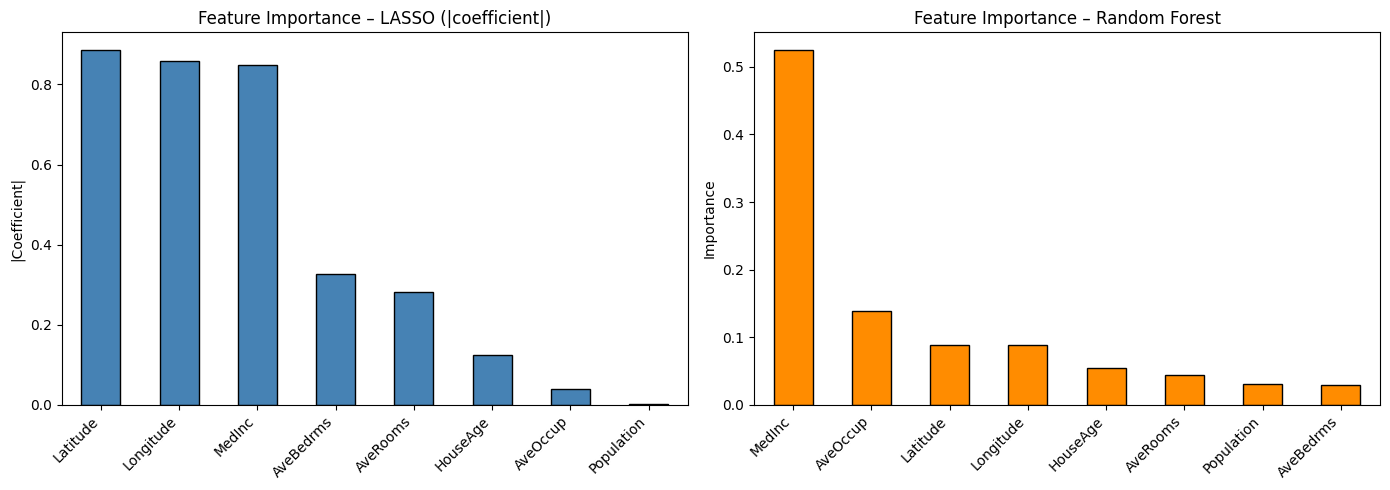


── Summary ───────────────────────────────────────────────
Top 3 by LASSO          : ['Latitude', 'Longitude', 'MedInc']
Top 3 by Random Forest  : ['MedInc', 'AveOccup', 'Latitude']


In [29]:

# Feature selection – top 3 important features via LASSO and Random Forest

# ── Method 1: LASSO coefficients ────────────────────────────────────────────
lasso_best = lasso_grid.best_estimator_
lasso_importance = pd.Series(
    np.abs(lasso_best.coef_), index=X.columns
).sort_values(ascending=False)

print("LASSO – feature importances (|coefficient|):")
print(lasso_importance.to_string(float_format='{:.6f}'.format))
print(f"\nTop 3 features (LASSO): {list(lasso_importance.head(3).index)}")

# ── Method 2: Random Forest feature importances ──────────────────────────────
rf_best = rf_grid.best_estimator_
rf_importance = pd.Series(
    rf_best.feature_importances_, index=X.columns
).sort_values(ascending=False)

print("\nRandom Forest – feature importances:")
print(rf_importance.to_string(float_format='{:.6f}'.format))
print(f"\nTop 3 features (Random Forest): {list(rf_importance.head(3).index)}")

# ── Side-by-side bar chart ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

lasso_importance.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Feature Importance – LASSO (|coefficient|)')
axes[0].set_ylabel('|Coefficient|')
axes[0].set_xticklabels(lasso_importance.index, rotation=45, ha='right')

rf_importance.plot(kind='bar', ax=axes[1], color='darkorange', edgecolor='black')
axes[1].set_title('Feature Importance – Random Forest')
axes[1].set_ylabel('Importance')
axes[1].set_xticklabels(rf_importance.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# ── Final summary ─────────────────────────────────────────────────────────────
top3_lasso = list(lasso_importance.head(3).index)
top3_rf    = list(rf_importance.head(3).index)
print("\n── Summary ───────────────────────────────────────────────")
print(f"Top 3 by LASSO          : {top3_lasso}")
print(f"Top 3 by Random Forest  : {top3_rf}")


## Task 2: Decision Tree Calculation

#### Given the dataset, please provide the detailed calculations to build a CART to predict `EnjoySport?` with the depth of 2.

| Index | Sky | Humidity | Water | Forecast | EnjoySport? | 
|----------|----------|----------|----------|----------|----------|
| 1| Sunny| Normal| Warm| Same| Yes|
| 2| Sunny| High| Warm| Same| Yes|
| 3| Rainy| High| Warm| Change| No|
| 4| Sunny| High| Cold| Change| Yes|
| 5| Sunny| Normal| Warm| Same| No|

- Base libraries like `numpy` can be used for math calculation, but `sklearn` is not allowed in this task.
- Submit your final answer as a PDF document. You may present your work in either handwritten form, typed, or in any other format that clearly demonstrates your full calculations and reasoning.